>**Alumnos**: *Adrián Ogáyar Sanchez y Arturo Barbero Pérez*

>**Grupo**: *11*

# Support Vector Machines

El objetivo de la primera parte de la práctica es familiarizarse con el uso del clasificador SVM que incorpora scikit-learn, para luego aplicarlo en la segunda parte de la práctica.

Comenzamos importando las librerías necesarias. Todas ellas han sido utilizadas y explicadas en prácticas anteriores, salvo **SVM** de **SciKit-Learn** que es el módulo que incorpora todos los algoritmos necesarios para las Support Vector Machines.

In [1]:
#Comprobar que realmente se usan luego todas

from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import sklearn.svm as svm

## Kernel Lineal

Continuamos cargando los datos del fichero ex6data1.mat, ex6data2.mat y ex6data3.mat. Este fichero contiene una serie de datos de entrenamiento y datos de validación necesarios para la realización del apartado 1.3 que veremos posteriormente.

In [2]:
datos1 = loadmat("ex6data1.mat")
datos2 = loadmat("ex6data2.mat")
datos3 = loadmat("ex6data3.mat")

datos1_x = datos1['X']
datos1_y = datos1['y']
print(datos1_x.shape)
print(datos1_y.shape)

datos2_x = datos2['X']
datos2_y = datos2['y']
print(datos2_x.shape)
print(datos2_y.shape)

datos3_x = datos3['X']
datos3_y = datos3['y']
print(datos3_x.shape)
print(datos3_y.shape)

xval = datos3['Xval']
yval = datos3['yval']
print(xval.shape)
print(yval.shape)

(51, 2)
(51, 1)
(863, 2)
(863, 1)
(211, 2)
(211, 1)
(200, 2)
(200, 1)


Definimos una función que se va a encargar de realizar un gráfico para poder visualizar los datos. Esta función recibe la componente 'X' y la clasificacion 'y'.

In [3]:
def graficaDatos(x, y):
    plt.figure()
    
    pos = (y == 1).ravel()
    neg = (y == 0).ravel()
    
    plt.scatter(x[pos, 0], x[pos, 1], color='black', marker='+')
    plt.scatter(x[neg, 0], x[neg, 1], color='yellow', edgecolors='black', marker='o')

    return

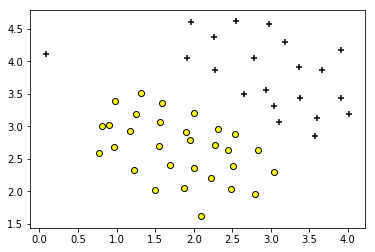

In [4]:
graficaDatos(datos1_x, datos1_y)

La clase *sklearn.svm.SVC* instancia un clasificador SVM utilizando el parámetro C de regularización y aplicando una función de kernel *kernel*. 

In [5]:
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(datos1_x, datos1_y.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Creamos una función que recibe el clasificador previamente entrenado y los datos de entrada. Este método se encarga de crear unas coordenadas que van desde los mínimos hasta los máximos de 'x' y realiza una predicción sobre estos datos. Devuelve las coordenadas y las predicciones realizadas.

In [6]:
def generarSeparacion(clf, x):

    x1 = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
    x2 = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
    x1, x2 = np.meshgrid(x1, x2)
    
    yp = clf.predict(np.array([x1.ravel(),x2.ravel()]).T).reshape(x1.shape)
    
    return (x1, x2, yp)

In [7]:
x1, x2, yp = generarSeparacion(clf, datos1_x)

Definiremos también una función encargada de completar la gráfica creada con *graficaDatos*. La completa añadiendo la frontera de decisión a esta. 

In [8]:
def graficaSeparacion(x, y, x1, x2, yp):
    
    graficaDatos(x,y)
    plt.contour(x1, x2, yp)
    
    return

### Resultado obtenido con C = 1

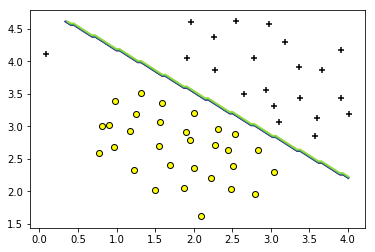

In [9]:
graficaSeparacion(datos1_x, datos1_y, x1, x2, yp)

### Resultado obtenido con C = 100

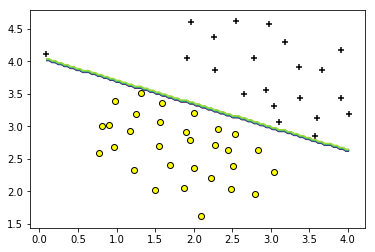

In [10]:
clf = svm.SVC(kernel='linear', C=100)

clf.fit(datos1_x, datos1_y.ravel())

x1, x2, yp = generarSeparacion(clf, datos1_x)

graficaSeparacion(datos1_x, datos1_y, x1, x2, yp)

Como podemos observar en las gráficas, el parámetro C funciona de manera contraria al parámetro $\lambda$ de las prácticas anteriores. Cuanto mayor es C, realiza una mejor separación entre los dos grupos de datos que tenemos, es decir, consigue que haya un menor *underfitting* y un mayor *overfitting* a los datos.
Sin embargo, cuanto menor es C, consigue que haya un mayor *underfitting* y un menor *overfitting*

## Kernel Gaussiano

A continuación utilizamos un kernel gaussiano para poder entrenar una SVM que clasifique correctamente el segundo conjunto de datos. 
Realizamos un proceso parecido al anterior, pero con los parametros: *kernel* = 'rbf' (equivalente a Gaussiano), *C* = 1, *gamma*= 1 / (2*sigma^2)*, donde *sigma* = 0.1

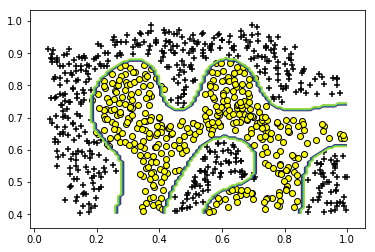

In [11]:
clf = svm.SVC(kernel='rbf', C=1, gamma=1/(2*0.1**2))

clf.fit(datos2_x, datos2_y.ravel())

x1, x2, yp = generarSeparacion(clf, datos2_x)

graficaSeparacion(datos2_x, datos2_y, x1, x2, yp)

## Elección de los parámetros $C$ y $\sigma$

En este caso tenemos que seleccionar los valores $C$ y $\sigma$ para el conjunto de datos de *ex6data3.mat*. Teniendo en este caso unos valores de validacion *Xval* e *yval*.

Para obtener los mejores valores de $C$ y $\sigma$ crearemos una función ***ajustarPorcentaje*** que reciba 2 vectores con los posibles valores de $C$ y de $\sigma$. Esta buscará la svm generada con los subconjuntos de estos parametros que tenga el mayor porcentaje de acierto respecto a los valores de validación, devolviendo una tupla $(C,\sigma)$ con los parametros ajustados.

In [12]:
def ajustarPorcentaje(C, Sigma, x, y, xval, yval) :
    mejorP = 0
    
    for c in C :
        for sigma in Sigma :
            clf = svm.SVC(kernel='rbf', C=c, gamma=1/(2*sigma**2))
            clf.fit(x, y)
            yv = clf.predict(xval)
            porcent = (100 * np.where(yv == yval)[0].size)/yval.size
            
            if(mejorP < porcent) :
                mejorP = porcent
                tup = (c,sigma)

    return tup

En este caso generamos un sólo vector que usaremos en ambos parámetros.

In [13]:
m = np.array([0.01,0.03,0.1,0.3,1,3,10,30])
ajustado = ajustarPorcentaje(m, m, datos3_x, datos3_y.ravel(), xval, yval.ravel())
print(ajustado)

(1.0, 0.1)


Finalmente mostramos la gráfica obtenida para comprobar que el resultado se ajusta a los valores deseados.

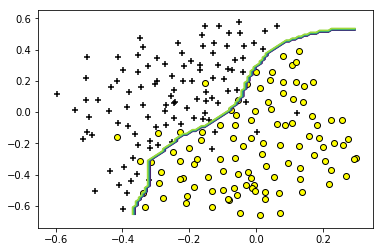

In [14]:
clf = svm.SVC(kernel='rbf', C=ajustado[0], gamma=1/(2*ajustado[1]**2))

clf.fit(datos3_x, datos3_y.ravel())

x1, x2, yp = generarSeparacion(clf, datos3_x)

graficaSeparacion(datos3_x, datos3_y, x1, x2, yp)

# Detección de spam

In [15]:
import codecs
import get_vocab_dict as vocabDic
import process_email as procEm
email_contents = codecs.open('spam/0001.txt', 'r', encoding='utf-8', errors='ignore').read()
email = procEm.email2TokenList(email_contents)
email.sort()
email = set(email)

In [16]:
dict = vocabDic.getVocabDict()
x = np.zeros(1899)
print(len(email))
resultado = [elem in email for elem in dict.keys() ]
resultado = [1 if elem == True else 0 for elem in resultado]
print(len(resultado))

162
1899


In [17]:
x = np.empty((0, 1899))
dict = vocabDic.getVocabDict()

directorio = 'spam'
for i in range(1, 501) :
    email_contents = codecs.open('{0}/{1:04d}.txt'.format(directorio, i), 'r', encoding='utf-8', errors='ignore').read()
    email = procEm.email2TokenList(email_contents)
    email = set(email)
    resultado = [elem in email for elem in dict.keys() ]
    resultado = [1 if elem == True else 0 for elem in resultado]
    x = np.vstack((x, resultado))
    
directorio = 'easy_ham'
for i in range(1, 2552) :
    email_contents = codecs.open('{0}/{1:04d}.txt'.format(directorio, i), 'r', encoding='utf-8', errors='ignore').read()
    email = procEm.email2TokenList(email_contents)
    email = set(email)
    resultado = [elem in email for elem in dict.keys() ]
    resultado = [1 if elem == True else 0 for elem in resultado]
    x = np.vstack((x, resultado))
    
directorio = 'hard_ham'
for i in range(1, 251) :
    email_contents = codecs.open('{0}/{1:04d}.txt'.format(directorio, i), 'r', encoding='utf-8', errors='ignore').read()
    email = procEm.email2TokenList(email_contents)
    email = set(email)
    resultado = [elem in email for elem in dict.keys() ]
    resultado = [1 if elem == True else 0 for elem in resultado]
    x = np.vstack((x, resultado))
    
x.shape

(3301, 1899)